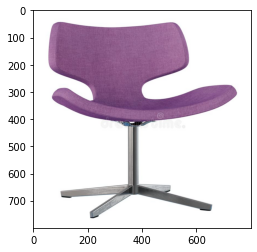

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import cv2

img = cv2.imread("chair.jpg", cv2.IMREAD_COLOR)
# img = cv2.resize(img,(128,128))
plt.imshow(img); plt.show()

In [7]:
# Define the helper function
def decode_segmap(image, nc=21):
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (255, 255, 255), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (255, 255, 255),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [8]:
import torchvision.transforms as T
import numpy as np

def segment(net, path, show_orig=True, dev='cuda'):
#     img = Image.open(path)
    Image.fromarray(path)
    if show_orig: 
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    trf = T.Compose([T.ToTensor()])#T.Resize(640), #T.CenterCrop(224),, T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    inp = trf(img).unsqueeze(0).to(dev)
    out = net.to(dev)(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om)
    plt.imshow(rgb); plt.axis('off'); plt.show()
    cv2.imwrite('mask2.png' , rgb)
    #   files.download('mask2.png')
    return rgb,om

In [9]:
from torchvision import models

dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

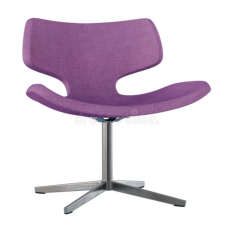

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 11.00 GiB total capacity; 8.12 GiB already allocated; 1.74 MiB free; 8.32 GiB reserved in total by PyTorch)

In [10]:
rgb,om=segment(dlab, img)

In [6]:
rgb.shape

(821, 1232, 3)

In [22]:
np.unique(om)

array([ 0, 15], dtype=int64)

In [7]:
rgb[rgb!=255]=0

In [8]:
rgb.shape

(821, 1232, 3)

In [9]:
import cv2
import numpy as np

# Read the images
foreground = cv2.imread("chair_man.jpg")
background = cv2.imread("background3.jpg", cv2.IMREAD_COLOR)
background = cv2.resize(background, (rgb.shape[1],rgb.shape[0]), interpolation = cv2.INTER_AREA)

alpha = rgb

# Convert uint8 to float
foreground = foreground.astype(float)
background = background.astype(float)
 
# Normalize the alpha mask to keep intensity between 0 and 1
alpha = alpha.astype(float)/255
 

 
# Multiply the foreground with the alpha matte
foreground = cv2.multiply(alpha, foreground)
 
# Multiply the background with ( 1 - alpha )
background = cv2.multiply(1.0 - alpha, background)
 
# Add the masked foreground and background.
outImage = cv2.add(foreground, background)
 
numpy_horizontal = np.hstack((img, outImage))

numpy_horizontal_concat = np.concatenate((img, outImage), axis=1)
# Display image
# cv2_imshow(numpy_horizontal_concat)
# cv2.waitKey(0)
# Display image
cv2.imwrite('res.png' , numpy_horizontal_concat)
# files.download('res.png')

True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


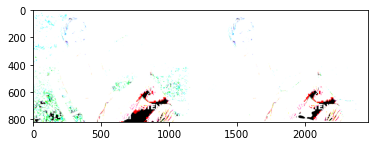

In [12]:
plt.imshow(numpy_horizontal_concat)

In [10]:
mask_out=cv2.subtract(rgb,img)
mask_out=cv2.subtract(rgb,mask_out)
mask_out[rgb == 0] = 255
#plt.imshow(mask_out); plt.show()
cv2.imwrite('out4.jpeg' , mask_out)
numpy_horizontal = np.hstack((img, mask_out))

numpy_horizontal_concat = np.concatenate((img, mask_out), axis=1)

In [18]:
# Read the images
foreground = cv2.imread("chair_man.jpg")

# Create a Gaussian blur of kernel size 7 for the background image
blurredImage = cv2.GaussianBlur(foreground, (31,31), 0)

# Convert uint8 to float
foreground = foreground.astype(float)
blurredImage = blurredImage.astype(float)

# Create a binary mask of the RGB output map using the threshold value 0
th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)

# Apply a slight blur to the mask to soften edges
alpha = cv2.GaussianBlur(alpha, (7,7),0)
 
# Normalize the alpha mask to keep intensity between 0 and 1
alpha = alpha.astype(float)/255
 
# Multiply the foreground with the alpha matte
foreground = cv2.multiply(alpha, foreground)

# Multiply the background with ( 1 - alpha )
background = cv2.multiply(1.0 - alpha, blurredImage)

 
# Add the masked foreground and background
outImage = cv2.add(foreground, background)
 
# Return a normalized output image for display
outImage= outImage#/255
numpy_horizontal = np.hstack((img, outImage))

numpy_horizontal_concat = np.concatenate((img, outImage), axis=1)
# Display image
# cv2_imshow(numpy_horizontal_concat)
# cv2.waitKey(0)
# # Display image
cv2.imwrite('res.png' , numpy_horizontal_concat)
# files.download('res.png')

True

In [19]:
# Load the foreground input image
foreground = cv2.imread("chair_man.jpg")

# Resize image to match shape of R-band in RGB output map
foreground = cv2.resize(foreground, (rgb.shape[1],rgb.shape[0]), interpolation = cv2.INTER_AREA)


 
# Create a background image by copying foreground and converting into grayscale
background = cv2.cvtColor(foreground, cv2.COLOR_BGR2GRAY)
 
# convert single channel grayscale image to 3-channel grayscale image
background = cv2.cvtColor(background, cv2.COLOR_GRAY2RGB)

 
# Convert uint8 to float
foreground = foreground.astype(float)
background = background.astype(float)
 
# Create a binary mask of the RGB output map using the threshold value 0
th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)
 
# Apply a slight blur to the mask to soften edges
alpha = cv2.GaussianBlur(alpha, (7,7),0)

# Normalize the alpha mask to keep intensity between 0 and 1
alpha = alpha.astype(float)/255
 
# Multiply the foreground with the alpha matte
foreground = cv2.multiply(alpha, foreground)
 
# Multiply the background with ( 1 - alpha )
background = cv2.multiply(1.0 - alpha, background)
 
# Add the masked foreground and background
outImage = cv2.add(foreground, background)
 
numpy_horizontal = np.hstack((img, outImage))

numpy_horizontal_concat = np.concatenate((img, outImage), axis=1)
# Display image
# cv2_imshow(numpy_horizontal_concat)
# cv2.waitKey(0)
# # Save image
cv2.imwrite('res1.png' , numpy_horizontal_concat)
# files.download('res.png')

True